## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# load data 
# ----------
congress_tweets = pd.read_csv("/Users/alexadia/Downloads/data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#choosing 10k
random.seed(64)
congress_tweets = congress_tweets.sample(10000)
congress_tweets.head(20)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
466999,1.169670e+18,RepSamGraves,2019-09-05T14:00:00-04:00,The USMCA will open new markets for our produc...,Sam Graves,Rep,3-Jan-01,11/7/1963,M,MO,6,Republican,"1,594,511","1,071,068","1,223,796","1,482,440"
106643,1.221870e+18,RepTedLieu,2020-01-27T13:57:30-05:00,"Three years ago today, President Trump put his...",Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
683087,1.141360e+18,USRepMikeDoyle,2019-06-19T10:52:42-04:00,Pennsylvania is in the midst of a natural gas ...,Michael F. Doyle,Rep,3-Jan-95,8/5/1953,M,PA,18,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434"
6286,1.225210e+18,USRepGaryPalmer,2020-02-05T19:06:32-05:00,#SOTU Fact: “… the United States has become th...,Gary Palmer,Rep,3-Jan-15,5/14/1954,M,AL,6,Republican,"1,318,255","729,547","795,696","1,255,925"
868650,1.182350e+18,RepElaineLuria,2019-10-10T13:41:43-04:00,Thank you to the Langley Chapter of the Air Fo...,Elaine Luria,Rep,3-Jan-19,8/15/1975,F,VA,2,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522"
275066,1.101240e+18,RepLipinski,2019-02-28T17:05:15-05:00,I sympathize w/ everyone who experienced delay...,Dan Lipinski,Rep,3-Jan-05,7/15/1966,M,IL,3,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"
730477,1.254180e+18,SenatorTimScott,2020-04-25T18:53:51-04:00,"Happy #NationalParkWeek! \nI may be biased, bu...",Tim Scott,Sen,2-Jan-13,9/19/1965,M,SC,Senate,Republican,"1,155,389","855,373","865,941","1,071,645"
630620,1.103720e+18,RepTimRyan,2019-03-07T12:57:05-05:00,"Mindfulness, yoga, and other wellness practice...",Tim Ryan,Rep,3-Jan-03,7/16/1973,M,OH,13,Democrat,"2,841,005","2,394,164","2,827,709","2,661,437"
646605,1.272530e+18,Jim_Jordan,2020-06-15T10:04:12-04:00,Why the double standard? https://twitter.com/h...,Jim Jordan,Rep,3-Jan-07,2/17/1964,M,OH,4,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
919022,1.337040e+18,RepNewhouse,2020-12-10T09:09:38-05:00,"""The only answer at this point is for Presiden...",Dan Newhouse,Rep,3-Jan-15,7/10/1955,M,WA,4,Republican,"1,221,747","1,742,718","1,755,396","1,290,670"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    spacy_words = [word for word in spacy_words if not word.startswith('RT')]  #Remove retweet flags
    
    common_tokens = ['RT', 'rt', 'QT', 'qt', 'via', 'amp', '"']  # some stuff in the word cloud I didn't want
    spacy_words = [word for word in spacy_words if word.lower() not in common_tokens]  #Remove common tokens
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

Now I tokenize

In [4]:
# now apply the function to all the columns in our dataframe
# ----------
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # can use apply here 
congress_tweets['tokens'] # visualize

466999    [The, USMCA, open, new, markets, products, Can...
106643    [Three, years, ago, today, President, Trump, r...
683087    [Pennsylvania, midst, natural, gas, boom,  , t...
6286      [SOTU, Fact, “, …, United, States, No, 1, prod...
868650    [Thank, Langley, Chapter, Air, Force, Associat...
                                ...                        
46987     [Thank, wonderful, law, enforcement, officers,...
612961    [My, wife, Renee, I, saddened, horrific, viole...
611100    [JECDems, 6, Unemployment, peaked, 10, Great, ...
435458    [TODAY, I, joined, Michigan, state, leaders, 6...
627832    [USDA, released, details, CFAP2, relief, 14B, ...
Name: tokens, Length: 10000, dtype: object

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: Word Cloud

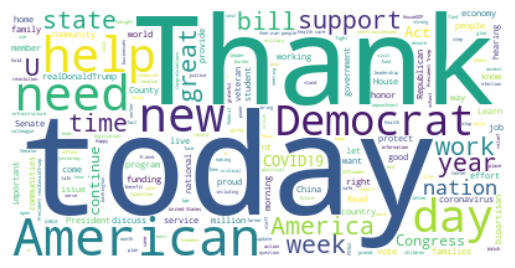

In [5]:
# Republican tweets
repub_tweets = congress_tweets[congress_tweets['party'] == 'Republican'].copy()

repub_text = ' '.join(repub_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
repub_wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(repub_text)             # change the background color


# plot 
plt.imshow(repub_wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot 

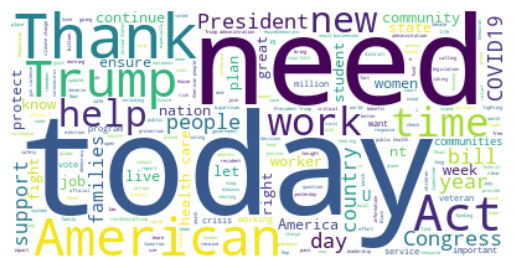

In [6]:
# Democrat tweets
demo_tweets = congress_tweets[congress_tweets['party'] == 'Democrat'].copy()

demo_text = ' '.join(demo_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
demo_wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(demo_text)             # change the background color


# plot 
plt.imshow(demo_wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot 

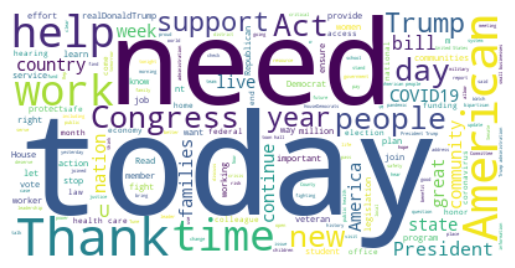

In [7]:
# Representative tweets
rep_tweets = congress_tweets[congress_tweets['position'] == 'Rep'].copy()

rep_text = ' '.join(rep_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
rep_wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(rep_text)             # change the background color


# plot 
plt.imshow(rep_wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

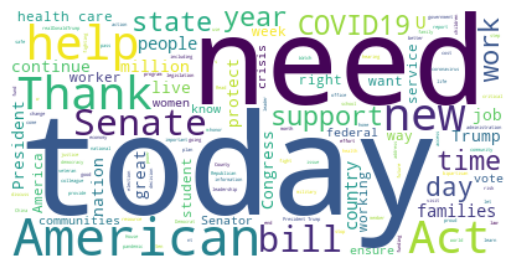

In [8]:
sen_tweets = congress_tweets[congress_tweets['position'] == 'Sen'].copy()

sen_text = ' '.join(sen_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
sen_wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(sen_text)             # change the background color


# plot 
plt.imshow(sen_wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

### EDA 2: Word Counts

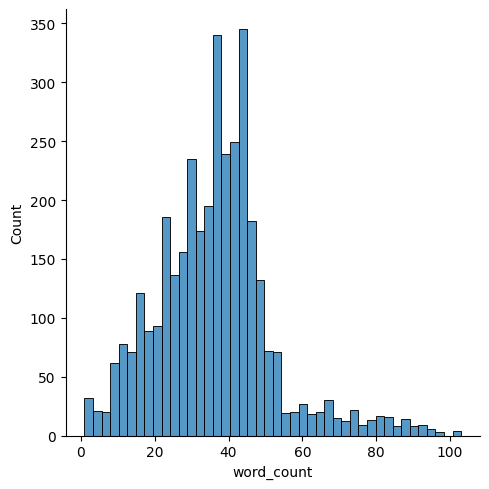

In [9]:
#Republican tweets
repub_tweets['word_count'] = repub_tweets['text'].apply(lambda x: len(str(x).split()))
sns.displot(repub_tweets,           # specify data 
            x="word_count") # x-axis feature
plt.show()

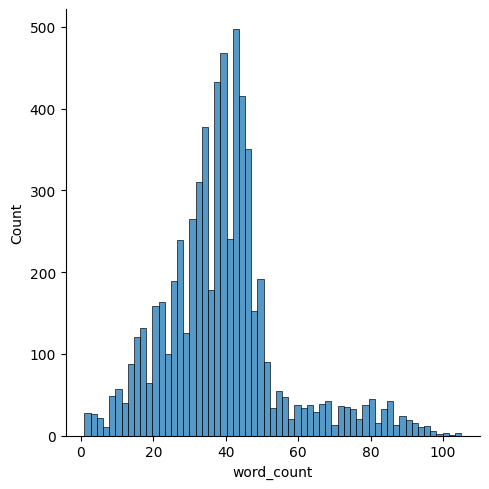

In [10]:
#Democrat tweets
demo_tweets['word_count'] = demo_tweets['text'].apply(lambda x: len(str(x).split()))
sns.displot(demo_tweets,           # specify data 
            x="word_count") # x-axis feature
plt.show()

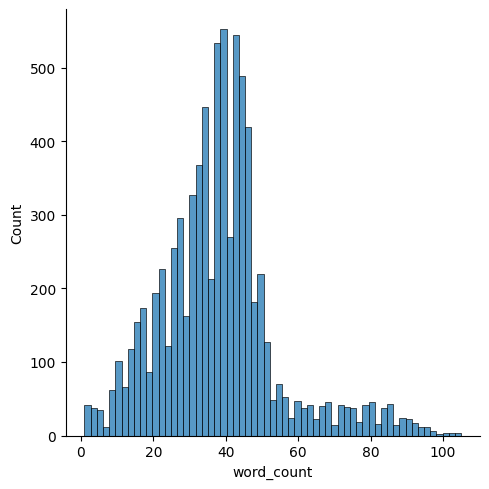

In [11]:
#Rep tweets
rep_tweets['word_count'] = rep_tweets['text'].apply(lambda x: len(str(x).split()))
sns.displot(rep_tweets,           # specify data 
            x="word_count") # x-axis feature
plt.show()

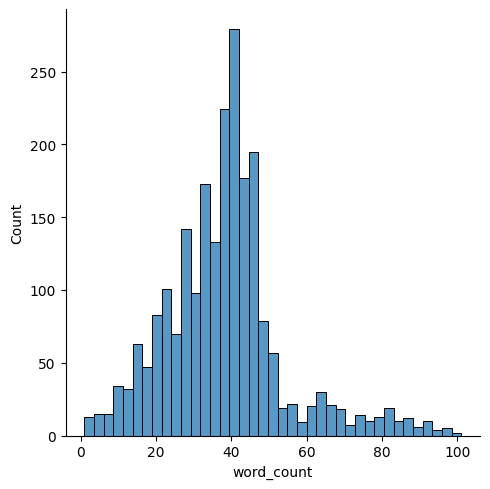

In [12]:
#Sen tweets
sen_tweets['word_count'] = sen_tweets['text'].apply(lambda x: len(str(x).split()))
sns.displot(sen_tweets,           # specify data 
            x="word_count") # x-axis feature
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [13]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


Rubio Tweets


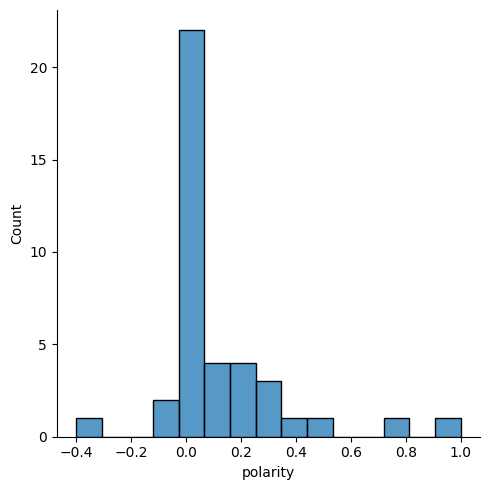

Warren Tweets


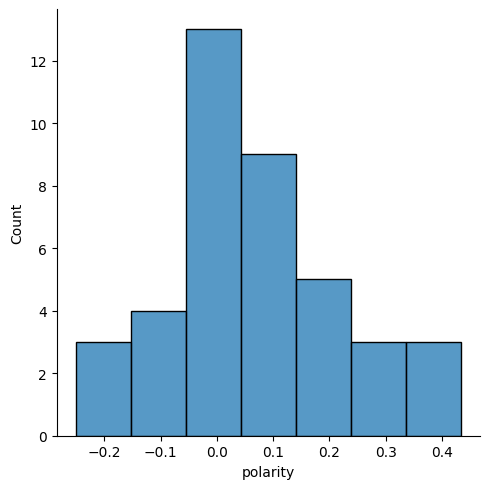

In [14]:
#Two legislators comparison
rubio_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Marco Rubio'].copy()
warren_tweets = congress_tweets[congress_tweets['name_wikipedia'] == 'Elizabeth Warren'].copy()

print("Rubio Tweets")
sns.displot(rubio_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

print("Warren Tweets")
sns.displot(warren_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

Democrat Tweets


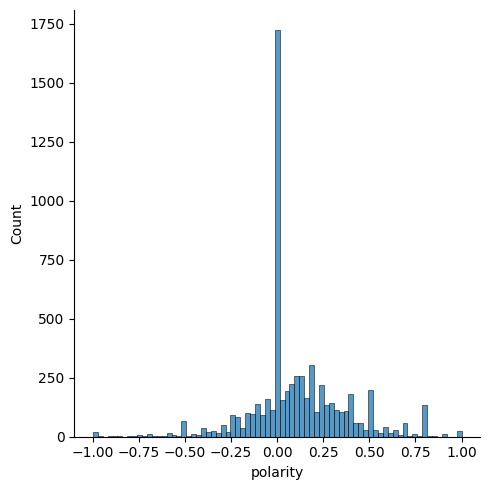

Republican Tweets


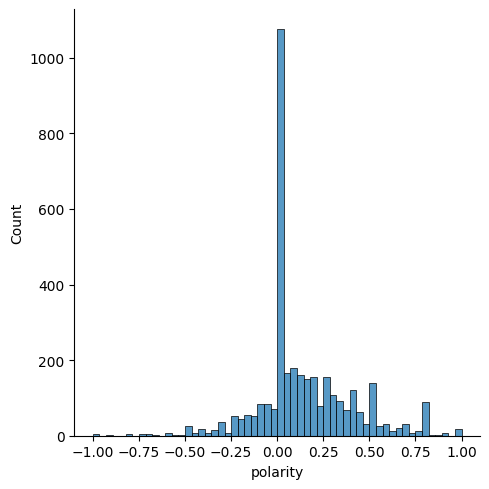

In [15]:
#Democrat vs Republican
demo_tweets = congress_tweets[congress_tweets['party'] == 'Democrat'].copy()
repub_tweets = congress_tweets[congress_tweets['party'] == 'Republican'].copy()

print("Democrat Tweets")
sns.displot(demo_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

print("Republican Tweets")
sns.displot(repub_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()


Senate Tweets


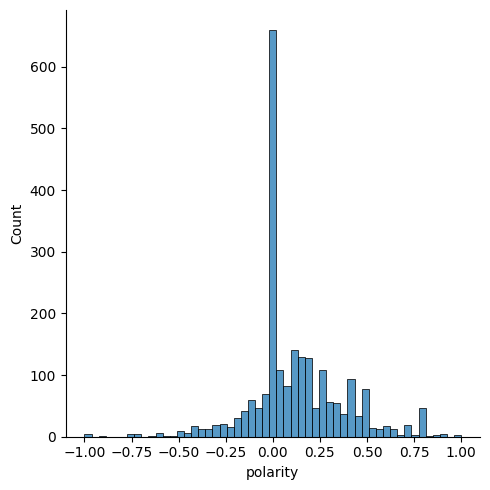

Representative Tweets


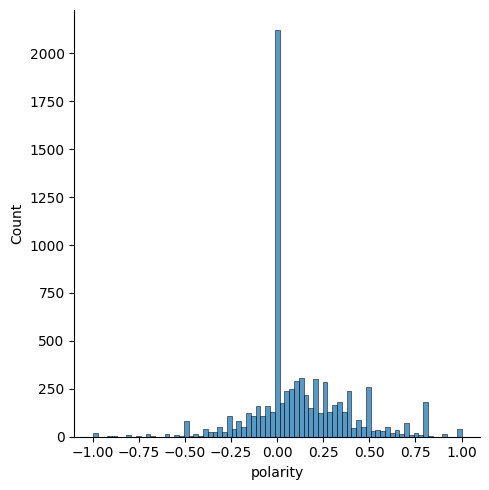

In [16]:
#Senators vs Reps
sen_tweets = congress_tweets[congress_tweets['position'] == 'Sen'].copy()
rep_tweets = congress_tweets[congress_tweets['position'] == 'Rep'].copy()

print("Senate Tweets")
sns.displot(sen_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

print("Representative Tweets")
sns.displot(rep_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()


## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [17]:
#add word counts
congress_tweets['word_count'] = congress_tweets['tokens'].apply(lambda x: len(str(x).split()))
#add subjectivity
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity) # iterate over "text" element
#add polarity
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)   # iterate over "text" element
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,word_count,subjectivity
466999,1.169670e+18,RepSamGraves,2019-09-05T14:00:00-04:00,The USMCA will open new markets for our produc...,Sam Graves,Rep,3-Jan-01,11/7/1963,M,MO,6,Republican,"1,594,511","1,071,068","1,223,796","1,482,440",The USMCA open new markets products Canada Mex...,0.187273,27,0.350909
106643,1.221870e+18,RepTedLieu,2020-01-27T13:57:30-05:00,"Three years ago today, President Trump put his...",Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Three years ago today President Trump reprehen...,0.200000,21,0.100000
683087,1.141360e+18,USRepMikeDoyle,2019-06-19T10:52:42-04:00,Pennsylvania is in the midst of a natural gas ...,Michael F. Doyle,Rep,3-Jan-95,8/5/1953,M,PA,18,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434",Pennsylvania midst natural gas boom tremendo...,0.142424,31,0.500000
6286,1.225210e+18,USRepGaryPalmer,2020-02-05T19:06:32-05:00,#SOTU Fact: “… the United States has become th...,Gary Palmer,Rep,3-Jan-15,5/14/1954,M,AL,6,Republican,"1,318,255","729,547","795,696","1,255,925",SOTU Fact “ … United States No 1 producer oil ...,0.100000,16,0.700000
868650,1.182350e+18,RepElaineLuria,2019-10-10T13:41:43-04:00,Thank you to the Langley Chapter of the Air Fo...,Elaine Luria,Rep,3-Jan-19,8/15/1975,F,VA,2,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522",Thank Langley Chapter Air Force Association in...,-0.400000,23,1.000000


### Engineered Text Features

In [19]:
# Engineered Features
engineered_features = congress_tweets[['word_count', 
                            'polarity', 
                            'subjectivity']].reset_index(drop = True)

### Bag-of-words or Tf-idf

In [20]:
# Frequency Based featurization
# initialize tf-idf function and set parameters
tf = TfidfVectorizer(tokenizer = rem_punc_stop,  # specify our function for remove punc and stop words
                     token_pattern = None)       # specify "None" to remove warning.

# apply tf-idf vectorizer to our data
tfidf_matrix =  tf.fit_transform(congress_tweets['text'])

# modify the output to be a dense matrix
dense_matrix = tfidf_matrix.todense()

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

NameError: name 'model' is not defined

In [22]:
# embedding based featurization
model = gensim.models.Word2Vec(congress_tweets['tokens'],    # specify data - tokens
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000) # sample size

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...